In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size']=12

# Introduction

In this notebook, you'll be working with the max flow problem.  Your first task is to familiarize yourself with the problem.  Max flow is one of the canonical problems in network analysis, so your learning resources are virtually limitless.  You'll find numerous descriptions of the problem, its formulation, and algorithms for solving it in textbooks and on the internet.  Feel free to "shop around" for an explanation that makes sense to you.  (It might even be helpful to read a couple of different viewpoints.)  One example that you should read, since it will serve as the basis for the notation and examples in this notebook, can be found in [Chapter 10](http://jeffe.cs.illinois.edu/teaching/algorithms/book/10-maxflow.pdf) of [this book](http://jeffe.cs.illinois.edu/teaching/algorithms/). For this and whatever other resources you pick, do a quick read to make sure you understand the basic concepts and know where to look when you have questions.  Then you can start on notebook tasks below.

# Representing a network using NetworkX

NetworkX is one of the best network libraries available in Python.  It's too slow for dealing with huge networks, but its simplicity and flexibility make it an excellent choice for rapid prototyping.  (You can always migrate your code over to a more optimized but less user-friendly library later.)  If you haven't worked with NetworkX before, you might find a quick run through the [tutorial](https://networkx.github.io/documentation/stable/tutorial.html) useful.

The following code generates the network on p. 2 of the notes linked in the introduction.  It also draws the network for comparison.  Since the nodes in the notes aren't labeled (except for 's' and 't'), we've just picked some labels.

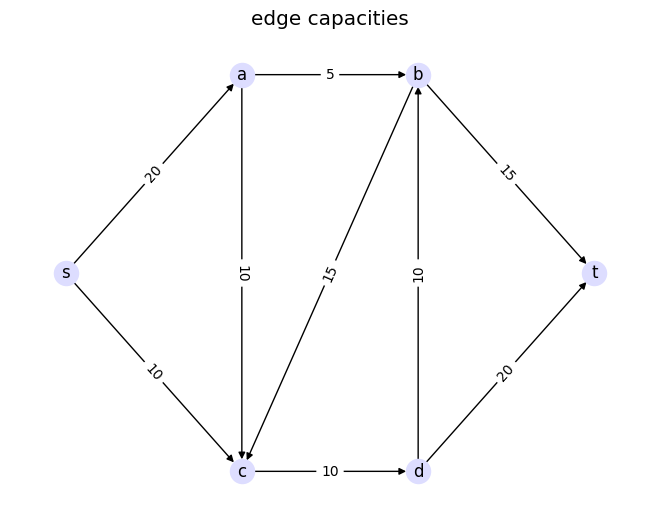

In [3]:

# list of edges to build the graph from
# each edge is represented as a tuple of the form
#   (start node, end node, capacity)
edges = [('s','a',20),('a','b',5),('b','t',15),('s','c',10),('c','d',10),('d','t',20),('a','c',10),('d','b',10),('b','c',15)]

# generate an empty digraph
G = nx.DiGraph()

# add the edges from the list
for a,b,c in edges:
    G.add_edge(a,b,capacity=c)

# dictionary describing where nodes will be plotted
pos = {
    's':(0,0), 'a':(1,.5), 'b':(2,.5), 't':(3,0),
    'c':(1,-.5), 'd':(2,-.5)
}

def draw_graph(G,pos,lbl,title):
    """
    Draws a digraph with edge labels and title.

    Args:
        G:     The Networkx graph.
        pos:   The node-position dictionary.
        lbl:   The node-label dictionary.
        title: The title for the plot.

    Returns:
        Nothing.
    """


    # draw the graph
    nx.draw(G,pos,node_color='#ddddff')

    # add node labels
    nx.draw_networkx_labels(G,pos)

    # add edge labels
    nx.draw_networkx_edge_labels(G,pos,edge_labels=lbl)

    # add a plot title
    plt.title(title);
    
# label with edge capacities
lbl = { (u,v):d['capacity'] for u,v,d in G.edges(data=True) }
draw_graph(G,pos,lbl,'edge capacities')

The code above is very simple in part because of the flexibility of NetworkX.  In particular, we're using the fact that NetworkX allows us to easily attach any information we want to a node or an edge; to each edge, we attach a number under the label 'capacity' to hold the capacity of the edge in the network.

# Max flow as a linear program (LP)

## Enumerating edges and nodes

In our first algorithm for max flow, we'll use the LP formulation.  To do so, we need to turn our objective and all constraints into the standard LP form.  To start with, let's see how we can represent a flow as a vector.  Since a flow needs to assign a value to each edge of our network, we can start by enumerating the network edges.  We'll call one edge 'edge 0' and another 'edge 1' and so on.  (Starting from index 0 is helpful since that's how Python indexes lists.)  In other words, we'll put our edges in some order $\{e_0,e_1,\ldots,e_{m-1}\}$ where $m$ is the number of edges.  Then a flow $f$ has a natural representation in $\mathbb{R}^m$; namely

$$
    f = (f_0,f_1,\ldots,f_{m-1})^T\qquad\text{where $f_i$ is the amount of flow across edge $i$}.
$$

To avoid getting too deep into the data structures used by NetworkX, here's a fact you can just accept for now: as long as you don't change the structure of a NetworkX graph, the edges are stored in *some* fixed order.  (Beware: if you modify the structure of the graph, the order of the nodes and edges can change.)  We don't really care what the order is, as long as we can count on it always being the same.  Here's a demonstration of the fact.

In [4]:
# do a few tests
for i in range(4):
    print('Test #{}'.format(i+1))
    print('  ', end='')
    
    # loop over the edges and print them out
    for a,b in G.edges():
        print((a,b), end='')
    print()

Test #1
  ('s', 'a')('s', 'c')('a', 'b')('a', 'c')('b', 't')('b', 'c')('c', 'd')('d', 't')('d', 'b')
Test #2
  ('s', 'a')('s', 'c')('a', 'b')('a', 'c')('b', 't')('b', 'c')('c', 'd')('d', 't')('d', 'b')
Test #3
  ('s', 'a')('s', 'c')('a', 'b')('a', 'c')('b', 't')('b', 'c')('c', 'd')('d', 't')('d', 'b')
Test #4
  ('s', 'a')('s', 'c')('a', 'b')('a', 'c')('b', 't')('b', 'c')('c', 'd')('d', 't')('d', 'b')


Notice how each time we print out the edges, they come out in exactly the same order.  There are many ways to enumerate the edges of $G$, but one way is just to use the ordering that NetworkX is already using.  Here's a function to do that.  It attaches a new property (called 'enum') to each edge of the graph that identifies where that edge occurs in the iteration above.

In [5]:
def enumerate_edges(G):
    """
    Enumerates the edges of a graph.

    Args:
        G: The Networkx graph.

    Returns:
        Nothing.

    On exit, each edge of the graph G will have an attached property
    called 'enum' holding the index of that edge in G.edges().
    """
    
    for i,(a,b) in enumerate(G.edges()):
        G[a][b]['enum'] = i

Here's the result in action.

In [6]:
enumerate_edges(G)
for a,b in G.edges():
    print('({},{}) is edge #{}'.format(a,b,G[a][b]['enum']))

(s,a) is edge #0
(s,c) is edge #1
(a,b) is edge #2
(a,c) is edge #3
(b,t) is edge #4
(b,c) is edge #5
(c,d) is edge #6
(d,t) is edge #7
(d,b) is edge #8


### 💻 Exercise
We need a similar enumeration of the nodes.  Implement the node enumeration function below.

In [7]:
def enumerate_nodes(G):
    """
    Enumerates the nodes of a graph.

    Args:
        G: The Networkx graph.

    Returns:
        Nothing.

    On exit, each node of the graph G will have an attached property
    called 'enum' holding the index of that edge in G.nodes().
    """
    
    # YOUR CODE HERE
    for i, v in enumerate(G.nodes()):
        G.nodes[v]['enum'] = i

In [8]:
#
# Test the graph enumeration code
#

# here are the answers that should come up
ans = [('s', 0), ('a', 1), ('b', 2), ('t', 3), ('c', 4), ('d', 5)]

# enumerate the nodes
enumerate_nodes(G)

# check against the known answer
for v,i in ans:
    assert( G.nodes[v]['enum'] == i )
    
print('All tests passed.')

All tests passed.


## The objective vector

With the nodes enumerated, we would like to write the objective function

$$
|f| = \sum_w f(s\to w) - \sum_u f(u\to s)
$$

in vector form as $w^Tf$.  By examining the formula, we can see that $w$ should be a vector with one entry for each edge in the graph.  If the edge originates at $s$, the corresponding entry in $w$ should be 1.  If the edge terminates at $s$, the corresponding entry in $w$ should be -1.  If the edge is not attached to $s$ at all, then the corresponding entry in $w$ should be 0.  Here's an implementation of that idea.

In [9]:
def max_flow_objective(G,s):
    """
    Computes the max flow objective as a vector w such that w.dot(f) gives the
    value of a flow.

    Args:
        G: The networkx graph.
        s: The source node.

    Returns:
        w: The objective vector.
    """
    
    import numpy as np

    # count the number of edges
    m = len( G.edges() )
    
    # initialize a zero vector
    w = np.zeros(m)
    
    # loop over edges leaving s
    for u in G.successors(s):
        
        # get the index in w
        i = G[s][u]['enum']
        
        # insert the entry in w
        w[i] = 1
        
    # loop over edges entering s
    for u in G.predecessors(s):
        
        # get the index in w
        i = G[u][s]['enum']
        
        # insert the entry in w
        w[i] = -1
    
    return w

In [10]:
print(max_flow_objective(G,'s'))

[1. 1. 0. 0. 0. 0. 0. 0. 0.]


Notice above that the edge with index 0 is the $s\to a$ edge while the edge with index 1 is the $s\to c$ edge, so this objective vector makes sense.

## Completing the LP formulation

We're almost ready to solve the max flow problem as a linear program.  With a little reflection, you'll see that we can formulate max flow as

$$
\begin{align*}
\text{maximize}&\quad w^Tf\\
\text{subject to}&\quad f\ge 0\\
&\quad f\le c\\
&\quad Df = 0.
\end{align*}
$$

Here, $w$ is the objective vector defined above.  The constraints $f\ge 0$ and $f\le c$ should be interpreted as elementwise constraints on the vector $f$, where $c$ is the vector of capacities.  The matrix $D$ is the *divergence* matrix.  It has one row for each node other than $s$ and $t$ and is used to require that

$$
    \sum_u f(u\to v) - \sum_w f(v\to w) = 0\qquad\text{for all } v\notin\{s,t\}
$$

To keep things simple, let's put the rows of $D$ in the same order that the nodes are ordered in above.  Since $a$ has index $1$ (and $s$ is index $0$), the first row of $D$ should enforce that the divergence of the flow at $a$ is 0.  $a$ has one in-edge (from $s$) and two out-edges (to $b$ and $c$), so the constraint on the flow at $a$ is

$$
    f(s\to a) - f(a\to b) - f(a\to c) = 0.
$$

Looking above, we can see that the indices of the edges $s\to a$, $a\to b$ and $a\to c$ respectively in the edge enumeration are 0, 2 and 3.  So the constraint looks like

$$
    0 = f_0 - f_2 - f_3 = \begin{bmatrix}1&0&-1&-1&0&0&0&0&0\end{bmatrix}f,
$$

giving us the first row of $D$.  Considering the other 3 nodes in turn shows that $D$ for this problem should be

$$
\begin{bmatrix}
1&0&-1&-1&0&0&0&0&0\\
0&0&1&0&-1&-1&0&0&1\\
0&1&0&1&0&1&-1&0&0\\
0&0&0&0&0&0&1&-1&-1\\
\end{bmatrix}.
$$

### 💻 Exercise

Implement the ```div_constraints``` function below as described in its docstring.

If you're relatively new to writing code (or if you're just interested), here's a stream-of-consciousness walkthrough of writing this function.  The video not only shows you how to write the function, but also demonstrates a very important technique called **incremental development**.  The idea is that, instead of trying to write all the code you need in one big chunk, you instead start with a very simple approximation of the code you're trying to write, and mold it into the final result through a series of better and better approximations.

Note that this code was written in Python 2 and with slightly older versions of the libraries we're using, so your code will need to be a little different from the code in the video.

<center>
<table>
    <tr>
        <td>
        <a href="https://youtu.be/ZtYaEMk9QeU">
        <img src="https://img.youtube.com/vi/ZtYaEMk9QeU/hqdefault.jpg"><br>Forming the Divergence Constraint Matrix
        </a>
</td>
</tr>
</table>
</center>

In [63]:
def div_constraints(G,s,t):
    """
    Computes the divergence constraints matrix for the max flow LP problem.

    Args:
        G: The networkx graph object.
        s: The source node.
        t: The target node.

    Returns:
        The constraint matrix D defining the constraints D f = 0.  (The entries in the
        flow vector are assumed to be ordered according to the label 'enum' attached
        to each edge.)

    """
    
    # YOUR CODE HERE
    import numpy as np
    
    D = np.zeros((len(G.nodes())-2, len(G.edges())))
    i = 0
    for v in G.nodes():
        if v in [s, t]:
            continue
        for u in G.predecessors(v):
            D[i, G[u][v]['enum']] = 1
        for w in G.successors(v):
            D[i, G[v][w]['enum']] = -1
        i += 1
    return D

In [64]:
#
# A few test examples for the divergence constraints
# 

import numpy as np
from numpy.testing import assert_equal

print('Test 1')
G_test = nx.DiGraph()
G_test.add_edge('s','a')
G_test.add_edge('t','a')
enumerate_edges(G_test)
enumerate_nodes(G_test)
D = div_constraints(G_test,'s','t')
D_true = np.zeros((1,2))
D_true[ 0, G_test['s']['a']['enum'] ] = 1
D_true[ 0, G_test['t']['a']['enum'] ] = 1
print('Got')
print(D)
print('Expected')
print(D_true)
assert_equal( D, D_true )
print('OK')
print()

print('Test 2')
G_test = nx.DiGraph()
G_test.add_edge('s','a')
G_test.add_edge('a','t')
enumerate_edges(G_test)
enumerate_nodes(G_test)
D = div_constraints(G_test,'s','t')
D_true = np.zeros((1,2))
D_true[ 0, G_test['s']['a']['enum'] ] = 1
D_true[ 0, G_test['a']['t']['enum'] ] = -1
print('Got')
print(D)
print('Expected')
print(D_true)
assert_equal( D, D_true )
print('OK')
print()

print('Test 3')
G_test = nx.DiGraph()
G_test.add_edge('s','a')
G_test.add_edge('s','b')
G_test.add_edge('a','b')
G_test.add_edge('a','t')
G_test.add_edge('b','t')
enumerate_edges(G_test)
enumerate_nodes(G_test)
D = div_constraints(G_test,'s','t')
D_true = np.array([[1,  0, -1, -1,  0], [0,  1,  1,  0, -1]],dtype=float)
print('Got')
print(D)
print('Expected')
print(D_true)
assert_equal( D, D_true )
print('OK')
print()


print()
print('All tests passed')

Test 1
Got
[[1. 1.]]
Expected
[[1. 1.]]
OK

Test 2
Got
[[ 1. -1.]]
Expected
[[ 1. -1.]]
OK

Test 3
Got
[[ 1.  0. -1. -1.  0.]
 [ 0.  1.  1.  0. -1.]]
Expected
[[ 1.  0. -1. -1.  0.]
 [ 0.  1.  1.  0. -1.]]
OK


All tests passed


## Solving the max flow problem

With all the pieces in place, we're now ready to set up and solve the max flow problem.

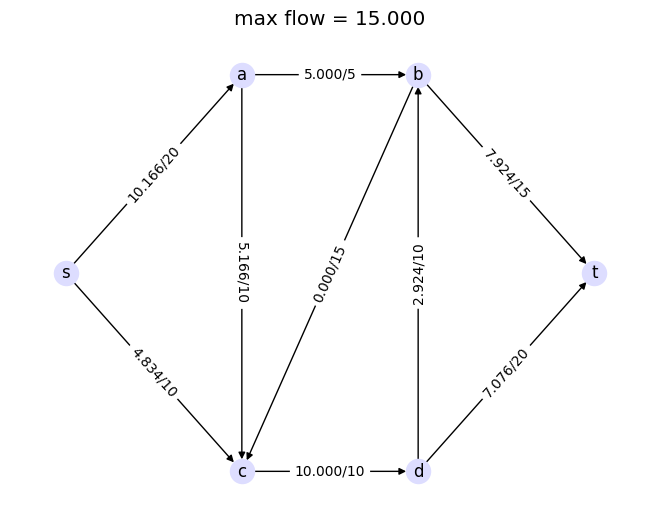

In [65]:
def solve_maxflow_lp(G,s,t):
    """
    Sets up and solves a max flow problem as a linear program.

    Args:
        G: The networkx graph object.
        s: The source node.
        t: The target node.

    Returns:
        val:  the value of the maximum flow
        flow: the maximum flow as a dictionary mapping edges to 
              flow amounts

    """

    import cvxpy as cvx

    # objective function
    w = max_flow_objective(G,s)

    # get divergence constraints matrix
    D = div_constraints(G,s,t)

    # get capacities as a vector
    cap = np.array( [d['capacity'] for u,v,d in G.edges(data=True)])

    # set up the LP
    m = len(G.edges())
    f = cvx.Variable(m)
    cons = [f>=0, f<=cap, D@f == 0]
    obj  = cvx.Maximize(w@f)
    prob = cvx.Problem( obj, cons )
    prob.solve()

    # test convergence
    assert( prob.status == 'optimal' )

    # create dict of flow values
    flow = { (u,v) : f[ d['enum'] ].value for u,v,d in G.edges(data=True)}
    
    return prob.value, flow

# flow and capacities as edge labels
val,flow = solve_maxflow_lp(G,'s','t')
lbl = { (u,v):'{:.3f}/{}'.format( flow[(u,v)], d['capacity'] ) for u,v,d in G.edges(data=True) }
draw_graph(G,pos,lbl,'max flow = {:.3f}'.format(val))

# The Ford-Fulkerson method

Although the max flow problem *can* be formulated and solved as a linear program, that doesn't mean in *should* be.  As is often the case with applications, knowledge of the particular problem class can lead to algorithms that are more efficient.

## The residual graph

As described in the reading for this notebook, the first step is to understand the residual graph.  Essentially, you build the residual graph from the original graph by taking every edge and adding a parallel edge facing the opposite direction.  The residual graph is used to produce a maximum flow as follows.  Initially the flow is set to zero on all edges (certainly a feasible flow since the divergence and capacity conditions are trivially satisfied).  The capacities in the residual graph are initialized to match those of $G$ for all original edges and set to zero for all the "backward" edges.  As we update the flow along an edge, we'll update those values to show how much capacity remains in the pipe.

In [66]:
#
# rebuild original graph, in case it's been messed up by now
#

# list of edges to build the graph from
# each edge is represented as a tuple of the form
#   (start node, end node, capacity)
edges = [('s','a',20),('a','b',5),('b','t',15),('s','c',10),('c','d',10),('d','t',20),('a','c',10),('d','b',10),('b','c',15)]

# generate an empty digraph
G = nx.DiGraph()

# add the edges from the list
for a,b,c in edges:
    G.add_edge(a,b,capacity=c)

# dictionary describing where nodes will be plotted
pos = {
    's':(0,0), 'a':(1,.5), 'b':(2,.5), 't':(3,0),
    'c':(1,-.5), 'd':(2,-.5)
}


In [67]:
def init_residual_graph(G):
    """
    Initializes the residual graph for the Ford-Fulkerson method.

    Args:
        G: The networkx graph object.

    Returns:
        G_res:  The residual graph.

    """
    
    import networkx as nx
    
    G_res = nx.DiGraph()
    for u,v,d in G.edges(data=True):
        G_res.add_edge(u,v,capacity=d['capacity'])
        G_res.add_edge(v,u,capacity=0)
        
    return G_res

def res_labels(G,G_res):
    """
    Produces remaining capacity labels suitable for visualizing a
    residual graph.

    Args:
        G:     The original networkx graph object.
        G_res: The residual graph

    Returns:
        G_res:  A dictionary of edge labels.

    """
    
    # initialize labels dictionary
    labels = {}
    
    # loop over G's edges
    for u,v in G.edges():
        
        # label has forward/backward edge capacity
        labels[(u,v)] = '{}/{}'.format(G_res[u][v]['capacity'], G_res[v][u]['capacity'])
        
    return labels

Here's a visualization of the residual graph for our problem.

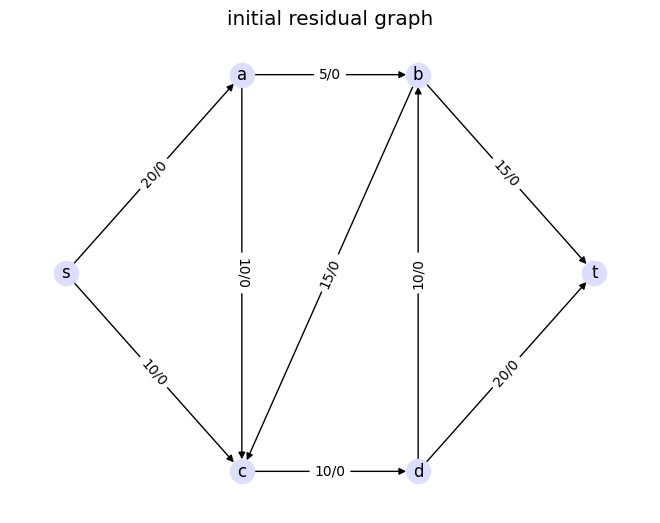

In [68]:
# draw the residual graph
G_res = init_residual_graph(G)
lbl = res_labels(G,G_res)
draw_graph(G,pos,lbl,'initial residual graph')

Since NetworkX isn't great at showing parallel edges, here's how to interpret the picture.  As before, the thicker part of the edge is the arrow head.  We're only showing the original directed edge.  In the original graph, each edge shown has a parallel edge going in the opposite direction.  The number before the slash in each label shows the remaining capacity of the "forward" edge.  The number after the slash shows the remaining capacity of the "backward" edge.

## Augmenting paths

As described in the reading, an **augmenting path** is a path from $s$ to $t$ in the residual graph that does not cross saturated edges.  (A saturated edge is an edge with no remaining capacity.)  Any time you find such a path, you can improve (increase) the flow you currently have by sending some flow along the path.  For example, consider the path $s\to a\to c\to d\to t$ in the graph above.  The edges crossed have remaining capacities (in traversal order) 20, 10, 10, 20.  Since all of these numbers are positive, this is an augmenting path.  This means that we can "push" more flow along that path.  In order to do this, we need to traverse the path in the residual graph, reducing the remaining capacity on all forward edges and increasing the remaining capacity of the associated backward edge.  The following function takes a residual graph, a path, and a value, and pushes extra flow along the path.

In [69]:
def augment_path(G_res,path,value):
    """
    Sends flow along an augmenting path in a residual graph.

    Args:
        G_res: The residual graph.
        path:  The path to push flow along.
        value: The amount of flow to push

    Returns:
        Nothing.
        
    This function updates the residual capacities on edges in the path.

    """

    # a path with n nodes has n-1 edges
    for i in range(len(path)-1):
        
        # get the starting and ending point of the edge
        u,v = path[i],path[i+1]
        
        # is there enough capacity left?
        assert( G_res[u][v]['capacity'] >= value )
        
        # update the residual graph
        G_res[u][v]['capacity'] -= value   # forward edge
        G_res[v][u]['capacity'] += value   # backward edge

Here's the example of pushing 5 units along $s\to a\to c\to d\to t$.  (We could push any amount up to 10.)

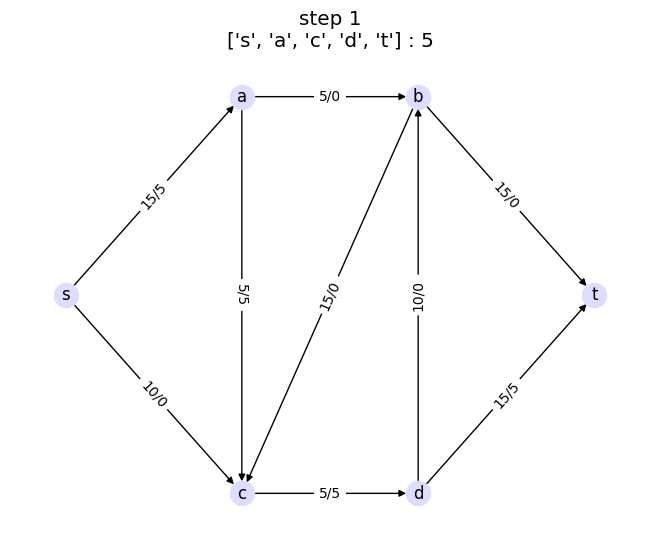

In [70]:
# initialize residual graph
G_res = init_residual_graph(G)

# steps in the augmenting path
path = ['s','a','c','d','t']

# value to push along the path
value = 5

# update the flow along the path
augment_path(G_res,path,value)

# draw the new residual graph
lbl = res_labels(G,G_res)
draw_graph(G,pos,lbl,'step 1\n{} : {}'.format(path,value))

Notice that the remaining capacities for the edges $s\to a$, $a\to c$, $c\to d$ and $d\to t$ have all decreased by 5 since we are sending 5 units of flow through these edges now.  The corresponding backward edges $a\to s$, $c\to a$, etc. have all had their remaining capacity increased to 5.  Notice that, in the Ford-Fulkerson method, the sum of the remaining capacities on each forward/backward edge pair always equals the capacity of the original edge in $G$.  It can be helpful to think of the capacities on the backward edges as recording how much flow we can "undo" along the corresponding forward edge.

For example, let's extend the previous example by sending 5 units of flow along the path $s\to c\to a\to b\to t$.

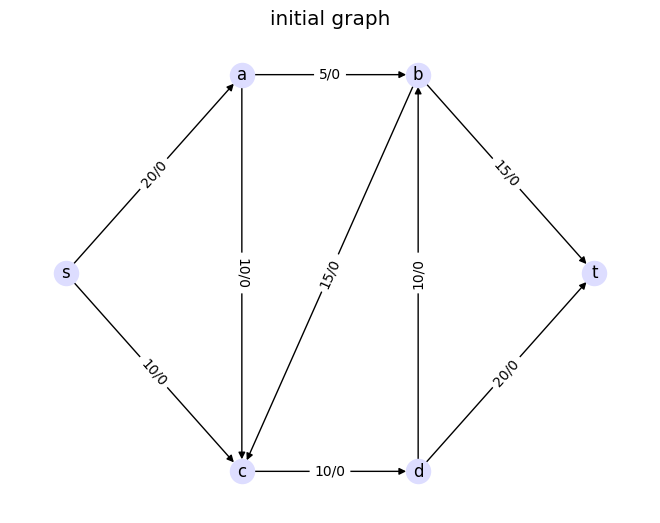

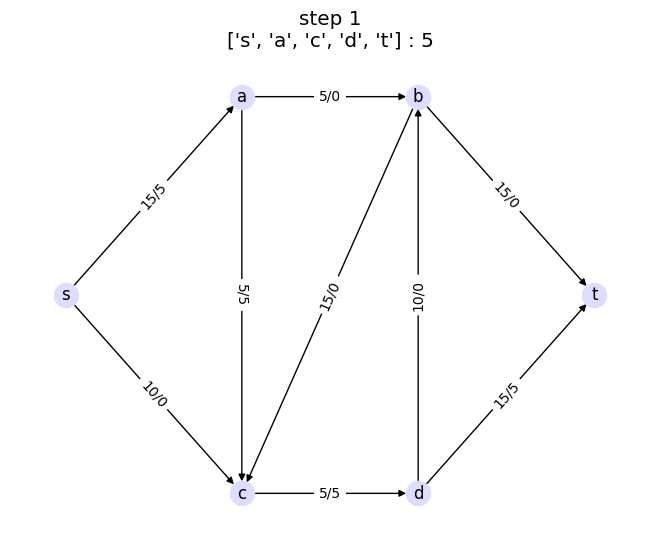

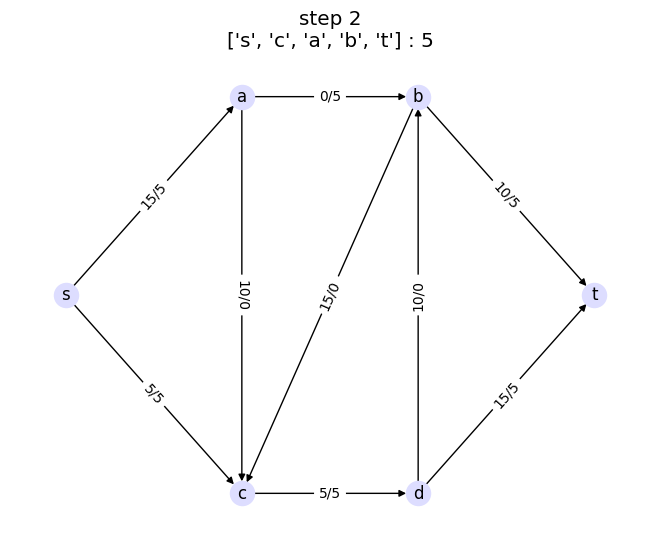

In [71]:
# list of paths and values
path_flows = [(['s','a','c','d','t'], 5),
              (['s','c','a','b','t'],5) ]

# initialize the residual graph
G_res = init_residual_graph(G)

# draw the original graph
lbl = res_labels(G,G_res)
draw_graph(G,pos,lbl,'initial graph')

# loop over list of augmenting paths
for i,(path,value) in enumerate(path_flows):
    
    # push flow along the path
    augment_path(G_res,path,value)
    
    # draw the result after the update
    lbl = res_labels(G,G_res)
    plt.figure()
    draw_graph(G,pos,lbl,'step {}\n{} : {}'.format(i+1,path,value))

Notice that, by sending 5 units backward from $c$ to $a$, we reversed the earlier choice of sending 5 units forward from $a$ to $c$.  The flow shown at the end of step 2 sends nothing across the $a\to c$ edge.  Even though it seems non-physical to send flow backward across an edge, it will make sense if you keep in mind the interpretation that the backward edge records flow that can be "un-pushed."  At each step, there should always be an equivalent choice of augmenting paths that only use forward edges.  For example, notice also that we could have gotten to the same result from the original graph by sending 5 units along $s\to a\to b\to t$ and 5 along $s\to c\to d\to t$.

### 💻 Exercise

Write a function that returns the solution to the max flow problem on the example graph.  **Important:** You don't need to write a generic max flow solver, just a function that solves this one particular problem.  Solve it by hand first, and then complete the function so that it returns a list like the ```path_flows``` list above.  Your solution must have the following properties.
- Each entry in the list is an augmenting path.
- The value pushed along each path respects the capacity constraints.
- The first entry in the list is ```(['s','a','b','c','d','t'],5)```.
- The resulting flow is maximal (i.e., has value 15).
- At the end, edge $s\to c$ is saturated.

In [82]:
def solve_exercise():
    """
    Solves the exercise above.
    
    Returns:
        A list of tuples.  The first entry in each tuple is a list of vertices
        representing an augmenting path.  The second entry in each tuple is the
        amount of flow to push along the path.
    """
    
    # YOUR CODE HERE
    # After solving by hand, the solution is:
    return [(['s','a','b','c','d','t'], 5),
            (['s','c','b','t'],5),
            (['s','c','d','t'],5)]

All tests passed


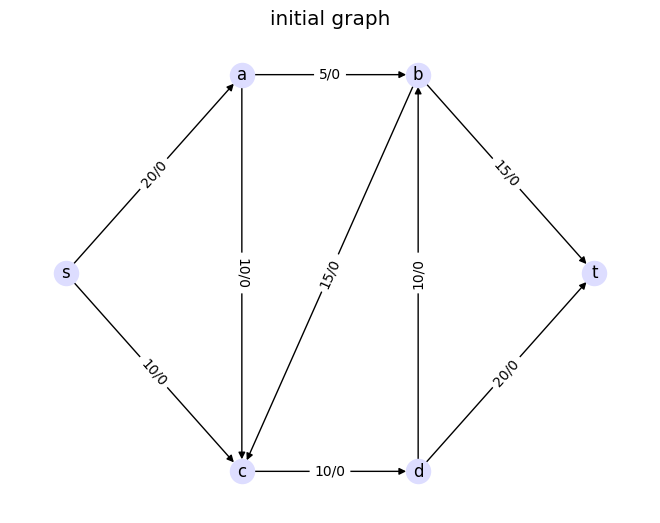

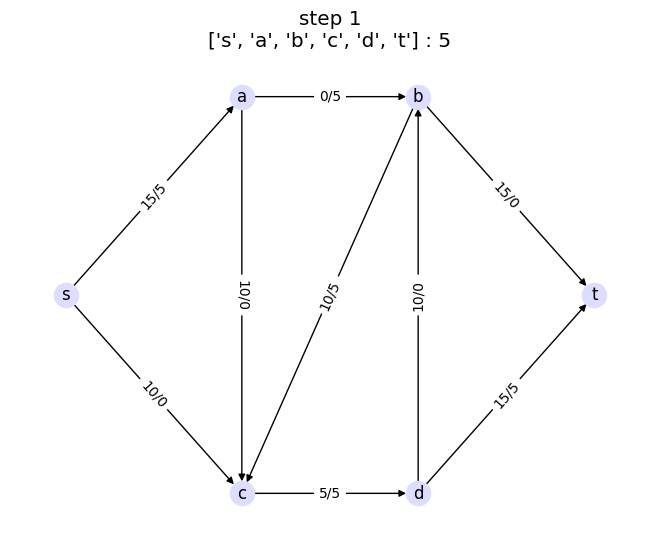

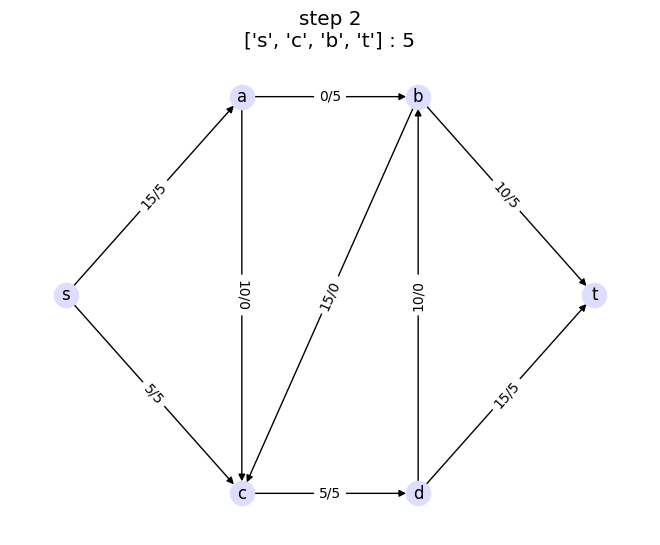

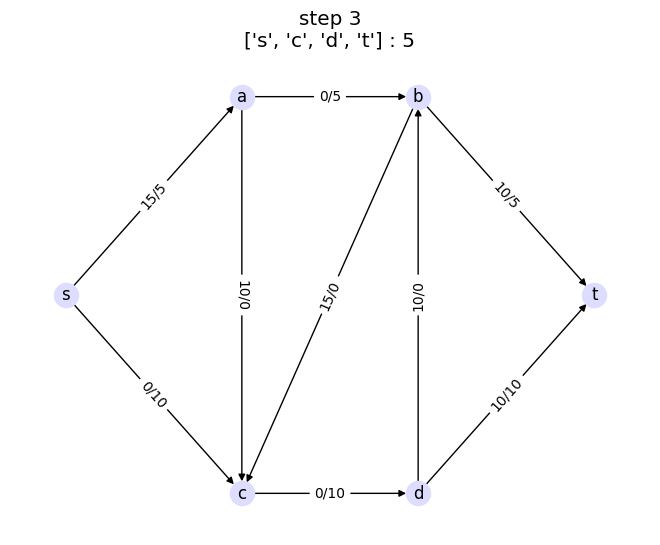

In [83]:
# visualize the solution
path_flows = solve_exercise()

# initialize the residual graph
G_res = init_residual_graph(G)

# draw the original graph
lbl = res_labels(G,G_res)
draw_graph(G,pos,lbl,'initial graph')

# loop over augmenting paths
for i,(path,value) in enumerate(path_flows):
    
    # push flow along the path
    augment_path(G_res,path,value)
    
    # draw the result
    lbl = res_labels(G,G_res)
    plt.figure()
    draw_graph(G,pos,lbl,'step {}\n{} : {}'.format(i+1,path,value))
    
# check that the solution follows all rules
# (the first two are checked by the augment_path function)
assert( path_flows[0] == (['s','a','b','c','d','t'],5) )
assert( G_res['a']['s']['capacity'] + G_res['c']['s']['capacity'] == 15 )
assert( G_res['s']['c']['capacity'] == 0)


print('All tests passed')